# Hidden Shift Problem

In this notebook, we first introduce the hidden shift problem, and classical and quantum algorithms to solve it. We then implement the quantum algorithm using Qiskit, and run it on a simulator and device.

## Contents

1. [The Hidden Shift Problem](#hsp)    
   1.1 [The Hidden Shift Problem](#problem)    
   1.2 [The Classical Solution](#classical-solution)    
   1.3 [The Quantum Solution](#quantum-solution) 
2. [Example: Super Oracle](#supo)    
   2.1 [Simulation](#supo-simulation)     
   2.2 [Device](#supo-device)
3. [Example: General Oracle](#geno)    
   3.1 [Simulation](#geno-simulation)     
   3.2 [Device](#geno-device)
4. [Problems](#problems)
5. [Breaking Poly1305 Encryption](#poly1305)
6. [References](#references)

## 1. The Hidden Shift Problem <a id='hsp'> </a>

The hidden shift problem is an oracle-based problem where the quantum solution shows exponential speedup. We can model some generally used cryptosystems like Poly1305 and CSIDH by the hidden shift problem, and it is also employed to benchmark quantum computers and classical simulators.

### 1.1 The Hidden Shift Problem <a id='problem'> </a>

Suppose two functions $f$ and $g$ with a relation $g(x)=f(x \oplus s)$, for some n-bit string $s$. Given an oracle $O$ that encodes $f$ and $g$, how can we find $s$ while accessing the oracle as little as possible?

### 1.2 The Classical Solution <a id='classical-solution'> </a>

Let's go through a specific example of the hidden shift algorithm for the case $n=4$ and $s=1011$. We employed the bent function $f$ and $g$ which are assumed explicitly as below.

|  x   | f(x) | g(x) |  x   | f(x) | g(x) |
|:----:|:----:|:----:|:----:|:----:|:----:|
| 0000 |  -1  |  -1  | 1000 |  -1  |   1  |
| 0001 |  -1  |   1  | 1001 |  -1  |  -1  |
| 0010 |  -1  |  -1  | 1010 |   1  |  -1  |
| 0011 |   1  |  -1  | 1011 |  -1  |  -1  |
| 0100 |  -1  |   1  | 1100 |  -1  |  -1  |
| 0101 |   1  |   1  | 1101 |   1  |  -1  |
| 0110 |  -1  |   1  | 1110 |   1  |   1  |
| 0111 |  -1  |  -1  | 1111 |   1  |  -1  |

The goal is to find $s$ such that $g(x)=f(x \oplus s)$. We can start from identifying all values of $f(x)$ and $g(x)$ by assigning $x$ one by one, and it aquires $O(2^n)$ of query complexity.

$$
F_1 = \{ x | f(x) = 1 \}, G_1 = \{ x | g(x) = 1 \}
$$

If $x_1 \in G_1$, then $x_1 \oplus s \in F_1$ by definition. Note that $F_1$ and $G_1$ are injective via shifting of $s$. If $s=0***$, then $x$ and $x \oplus s$ are both $0***$ or $1***$. Otherwise, if $s=1***$, then $x$ and $x \oplus s$ are mutually different. In this case, we could notice that $s$ is a kind of $1***$. By this strategy, we can characterize $s$ to be $1011$.

### 1.3 The Quantum Solution <a id='quantum-solution'> </a>

#### 1.3a Super-oracle case

If the given oracle lets you access to the Fourier-transformed function $\tilde{f}$, there exists an one-shot algorithm that directly returns $\left| s \right>$

![super-oracle-algorithm](images/super-oracle-algorithm.jpg)


We denote $f'(x) = f(x \oplus s)$.
The oracles $O_{f'}$ and $O_{\tilde{f}}$ flip phases of input state $\left| x \right>$ if the image of functions $f'$ and $\tilde{f}$ are $1$, so $O_{f'} \left| x \right> = (-1)^{f'(x)} \left| x \right>$ and $O_{\tilde{f}} \left| x \right> = (-1)^{\tilde{f}(x)} \left| x \right>$.


Remind that
$$
\left| y \right> \:\xrightarrow{H^{\otimes n}}\: \frac{1}{\sqrt{2^n}} \sum_{x \in \{ 0,1 \}^n} (-1)^{x \cdot y} \left| x \right>
$$


<details>
    <summary> Explain Equation (Click to Expand) </summary>

Let $\left| y \right> = \left| y_1 \right> \otimes \left| y_2 \right> \otimes \cdots \otimes \left| y_n \right>$.

We have $H \left| 0 \right> = \frac{1}{\sqrt{2}} \left( \left| 0 \right> + \left|1 \right> \right)$ and $H \left| 1 \right> = \frac{1}{\sqrt{2}} \left( \left| 0 \right> - \left| 1 \right> \right)$.

Then,
$$
\begin{aligned}
    H^{\otimes n} \left| y \right>  
        & = H \left| y_1 \right> \otimes H \left| y_2 \right> \otimes \cdots \otimes H \left| y_n \right> \\
        & = \sum_{x_1 = 0}^1 \frac{1}{\sqrt{2}} (-1)^{x_1 \cdot y_1} \left| x_1 \right> \otimes \sum_{x_2 =0}^1 \frac{1}{\sqrt{2}} (-1)^{x_2 \cdot y_2} \left| x_2 \right> \otimes \cdots \otimes \sum_{x_n =0}^1 \frac{1}{\sqrt{2}} (-1)^{x_n \cdot y_n} \left| x_n \right> \\
        & = \frac{1}{\sqrt{2^n}} \sum_{x \in \{ 0,1 \} ^n} (-1)^{x_1 \cdot y_1 + \cdots + x_n \cdot y_n} \left| x \right>
\end{aligned}
$$
    
</details>

Now, let's go through the steps of the algorithm:

<ol>
   <li>
        Initialize the inputs qubits to the $\left| 0 \right> ^{\otimes n}$ state. And apply Hadamard gates to the input register.  
$$
H^{\otimes n} \left| 00 \dots 0 \right> = \frac{1}{\sqrt{2^n}} \sum_{x \in \{ 0,1 \} ^n} \left| x \right>
$$

   </li>

   <li>
        Query the oracle $O_{f'}$.  
$$
O_{f'} \left[ \frac{1}{\sqrt{2^n}} \sum_{x \in \{ 0,1 \}^n} \left| x \right> \right] 
= \frac{1}{\sqrt{2^n}} \sum_{x \in \{ 0,1 \}^n} (-1)^{f(x \oplus s)} \left| x \right>
$$

   </li>

   <li>
        Apply Hadamard gates to the input register.  
$$
\begin{aligned}
    & H^{\otimes n} \left[ \frac{1}{\sqrt{2^n}} \sum_{x \in \{ 0,1 \} ^n} (-1)^{f(x \oplus s)} \left| x \right> \right] \\
    & = \frac{1}{2^n} \sum_{y \in \{ 0,1 \} ^n} \left[ \sum_{x \in \{ 0,1 \} ^n} (-1)^{x \cdot y} (-1)^{f(x \oplus s)} \right] \left| y \right> \\
    & = \frac{1}{2^n} \sum_{y \in \{ 0,1 \} ^n} (-1)^{s \cdot y} \left[ \sum_{x \in \{ 0,1 \} ^n} (-1)^{(x \oplus s) \cdot y} (-1)^{f(x \oplus s)} \right] \left| y \right>
\end{aligned}
$$

Rewrite $x \oplus s$ as $x$, then we get  
$$
= \frac{1}{2^n} \sum_{y \in \{ 0,1 \} ^n} (-1)^{s \cdot y} \left[ \sum_{x \in \{ 0,1 \} ^n} (-1)^{x \cdot y} (-1)^{f(x)} \right] \left| y \right>
$$

However the term inside square brackets is nothing but the Fourier trasnform  
$$
= \frac{1}{\sqrt{2^n}} \sum_{y \in \{ 0,1 \} ^n} (-1)^{s \cdot y} (-1)^{\tilde{f}(y)} \left| y \right>
$$

   </li>

   <li>
        Query the oracle $O_{\tilde{f}}$.
$$
\begin{aligned}
    & O_{\tilde{f}} \left[ \frac{1}{\sqrt{2^n}} \sum_{y \in \{ 0,1 \} ^n} (-1)^{s \cdot y} (-1)^{\tilde{f}(y)} \left| y \right> \right] \\
    & = \frac{1}{\sqrt{2^n}} \sum_{y \in \{ 0,1 \} ^n} (-1)^{s \cdot y} (-1)^{\tilde{f}(y)} (-1)^{\tilde{f}(y)} \left| y \right> \\
    & = \frac{1}{\sqrt{2^n}} \sum_{y \in \{ 0,1 \} ^n} (-1)^{s \cdot y} \left| y \right>
\end{aligned}
$$
        
   </li>

   <li>
        Apply the Hadamard gates.
$$
\begin{aligned}
    & H^{ \otimes n} \left[ \frac{1}{\sqrt{2^n}} \sum_{y \in \{ 0,1 \} ^n} (-1)^{s \cdot y} \left| y \right> \right] \\
    & = \left| s \right>
\end{aligned}
$$

Finally, we can retrieve $\left| s \right>$
        
   </li>
</ol>

#### 1.3b General case

For the general cases, we can apply this algorithm, which has time complexity $O(n)$.

![general-oracle-algorithm](images/general-oracle-algorithm.jpg)

Before we learn about this algorithm, Let's point out some definitions.The definitions of Hadamard Gate and Fourier Transform are as follows.

$$
H \left| x \right> = \sum_{y} (-1)^{x \cdot y} \left| y \right>
$$

$$
\tilde{f}(x) = \frac{1}{2^n} \sum_{y} (-1)^{x \cdot y}f(y)
$$

Now let's go through the steps of this algorithm:

<ol>
   <li>
        Apply Hadamard gates to the input register.  
$$
H \left| 0 \right> \left| 0 \right>^{\otimes n} \left| 0 \right>^{\otimes n}
= \frac{1}{\sqrt{2^{2n+1}}} \sum_{b, x, y} \left| b \right> \left| x \right> \left| y \right>
$$

   </li>

   <li>
        Apply CNOT gate to second and third qubits.  
$$
I \otimes CX \left[ \frac{1}{\sqrt{2^{2n+1}}} \sum_{b, x, y} \left| b \right> \left| x \right> \left| y \right> \right]
= \frac{1}{\sqrt{2^{2n+1}}} \sum_{b, x, y} \left| b \right> \left| x \right> \left| x + y \right>
$$

   </li>

   <li>
        Query the oracle $CO_g$ and $CO_f$.  
$$
\begin{aligned}
    & CO_f CO_g \left[ \frac{1}{\sqrt{2^{2n+1}}} \sum_{b, x, y} \left| b \right> \left| x \right> \left| x + y \right> \right] \\
    & = \frac{1}{\sqrt{2^{2n+1}}} \left[ \left| 0 \right> \sum_{x, y} f(x + y) \left| x \right> \left| x + y \right> + \left| 1 \right> \sum_{x, y} g(x + y) \left| x \right> \left| x + y \right> \right]
\end{aligned}
$$

   </li>

   <li>
        Apply the CNOT gate to to second and third qubits.  
$$
\begin{aligned}
    & I \otimes CX \left[ \frac{1}{\sqrt{2^{2n+1}}} \left[ \left| 0 \right> \sum_{x, y} f(x + y) \left| x \right> \left| x + y \right> + \left| 1 \right> \sum_{x, y} g(x + y) \left| x \right> \left| x + y \right> \right] \right] \\
    & = \frac{1}{\sqrt{2^{2n+1}}} \left[ \left| 0 \right> \sum_{x, y} f(x + y) \left| x \right> \left| y \right> + \left| 1 \right> \sum_{x, y} g(x + y) \left| x \right> \left| y \right> \right]
\end{aligned}
$$

   </li>

   <li>
        Apply Hadamard gates.  
$$
\begin{aligned}
    & H \left[ \frac{1}{\sqrt{2^{2n+1}}} \left[ \left| 0 \right> \sum_{x, y} f(x + y) \left| x \right> \left| y \right> + \left| 1 \right> \sum_{x, y} g(x + y) \left| x \right> \left| y \right> \right] \right] \\
    & = \cdots \\
    & = \frac{1}{2} \sum_{(b, x')} \left[ 1 + (-1)^{(1, s) \cdot (b, x')} \right] \tilde{f}(x') \left| b, x', x' \right>
\end{aligned}
$$

<details>
    <summary> Explain Equation (Click to Expand) </summary>

$$
\begin{aligned}
    & H \left[ \frac{1}{\sqrt{2^{2n+1}}} \left[ \left| 0 \right> \sum_{x, y} f(x + y) \left| x \right> \left| y \right> + \left| 1 \right> \sum_{x, y} g(x + y) \left| x \right> \left| y \right> \right] \right] \\
    & = \frac{1}{2^{2n+1}} \left[ \left( \left| 0 \right> + \left| 1 \right> \right) \sum_{x, y, x', y'} (-1)^{x \cdot x'} (-1)^{y \cdot y'} f(x + y) \left| x' \right> \left| y' \right> \right. \\
    & \quad + \left. \left( \left| 0 \right> - \left| 1 \right> \right) \sum_{x, y, x', y'} (-1)^{x \cdot x'} (-1)^{y \cdot y'} g(x + y) \left| x' \right> \left| y' \right> \right] \\
    & = \frac{1}{\sqrt{2}} \left[ \left| + \right> \frac{1}{2^{n}} \sum_{x, y, x', y'} (-1)^{x \cdot x'} (-1)^{y \cdot x'} f(x + y) \left| x' \right> (-1)^{y \cdot x'} (-1)^{y \cdot y'} \left| y' \right> \right. \\
    & \quad + \left. \left| - \right> \frac{1}{2^n} \sum_{x, y, x', y'} (-1)^{x \cdot x'} (-1)^{y \cdot x'} (-1)^{s \cdot x'} f(x + y + s) \left| x' \right> (-1)^{y \cdot x'} (-1)^{s \cdot x'} (-1)^{y \cdot y'} \left| y' \right> \right]
\end{aligned}
$$

By the definition of $\tilde{f}(x')$,  
$$
\begin{aligned}
    & = \frac{1}{\sqrt{2}} \left[ \left| + \right> \sum_{x'} \tilde{f}(x') \left| x' \right> \sum_{y,y'} (-1)^{y \cdot x' + y \cdot y'} \left| y' \right> + \left| - \right> \sum_{x'} \tilde{f}(x') \left| x' \right> \sum_{y,y'}(-1)^{y \cdot x'+ s \cdot x' + y \cdot y'} \left| y' \right> \right] \\
    & = \frac{1}{2} \left[ \left| 0 \right> \sum_{x'} \left( 1 + (-1)^{s \cdot x'} \right) \tilde{f}(x') \left| x' \right> \frac{1}{2^{n}} \sum_{y, y'} (-1)^{y \cdot x' + y \cdot y'} \left| y' \right> \right. \\
    & \quad + \left. \left| 1 \right> \sum_{x'} \left( 1 - (-1)^{s \cdot x'} \right) \tilde{f}(x') \left| x' \right> \frac{1}{2^{n}} \sum_{y, y'} (-1)^{y \cdot x' + y \cdot y'} \left| y' \right> \right]
\end{aligned}
$$

Consider that $\frac{1}{2^{n}} \sum_{y, y'} (-1)^{y \cdot x' + y \cdot y'} \left| y' \right> = HH \left| x' \right> = \left| x' \right>$. Then we can simplify the equation again with the binary index $b$.  
$$
= \frac{1}{2} \sum_{b, x'} \left[ 1 + (-1)^{b + s \cdot x'} \right] \tilde{f}(x') \left| b, x', x' \right>
$$

As $x'$ is just an index, we simply denote it by $x$ again.  
$$
= \frac{1}{2} \sum_{(b, x)} \left[ 1 + (-1)^{(1, s) \cdot (b, x)} \right] \tilde{f}(x) \left| b, x, x \right>
$$

</details>

In conclusion, we get the following state as a result of the algorithm.  
$$
A \left| 0, 0^{\otimes n}, 0^{\otimes n} \right> = \frac{1}{2} \sum_{(b, x)} \left[ 1 + (-1)^{(1, s) \cdot (b, x)} \right] \tilde{f}(x) \left| b, x, x \right>
$$

Now we can measure the first two registers, $\left| b, x \right>$. The probability of getting a result $\left| a_0, a \right>$ is  
$$
\begin{aligned}
    P(a_0, a)
        & = \left| \left< a \middle| \frac{1}{2} \sum_{(b, x)} \left[ 1 + (-1)^{(1, s) \cdot (b, x)} \right] \tilde{f}(x) \middle| b, x \right> \right| ^2 \\
        & = \frac{1}{4} \cdot \left| 1 + (-1)^{(1, s) \cdot (a_0, a)} \right| ^2 \cdot \left| \tilde{f}(a) \right| ^2 \\
        & = \frac{1}{4} \cdot 4 \delta ((1, s) \cdot (a_0, a)) \cdot \frac{1}{2^n} \\
        & = \frac{1}{2^n} \cdot \delta ((1, s) \cdot (a_0, a))
\end{aligned}
$$

It clearly states that the result is an uniform superposition of the states that are orthogonal to the state $\left| 1, s \right>$.

We need $n$ independent bitstrings to uniquely characterize the n-bit string $s$. We could repeat this algorithm a total number of $O(n)$ times to get a constant probability to get a sufficient number of bitstrings.

   </li>
</ol>

## 2. Example: Super Oracle <a id='supo'> </a>

Let's go through a specific example of the hidden shift algorithm for the case $n=4$ and $s=1011$.

1. Apply Hadamard gates on every qubit.

2. Perform a shift operation for the given shift $s=1011$.

3. Apply some bent function $f$.

4. Apply the shift operation again.

5. Apply Hadamard gates again.

7. Apply the Fourier transformed function $\tilde{f}$.

8. Apply Hadamard gates again.

9. Finally, measure all qubits to find the hidden shift $s$, which will turn out to be $1011$

$$
\left| s \right> = \left| 1011 \right>
$$

### 2.1 Qiskit Implementation <a id='supo-simulation'> </a>

We'll now walk through the hidden-shift algorithm implementation in Qiskit for a six bit string $s=1011$. We first set the number of qubits used in the experiment, and the hidden bit string $s$ to be found by the algorithm. The hidden bit string $s$ together with the function $f$ determines the circuit for the quantum oracle.

In [1]:
# initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, QuantumCircuit, transpile, assemble
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

We first set the number of qubits used in the experiment, and the hidden bit string $s$ to be found by the algorithm.

In [2]:
n = 4         # number of input qubits
s = '1011'    # the hidden shifting binary string

We then use Qiskit to encode the oracle.

From now on, we would see how we set $O_{g}$ and $O_{\tilde{f}}$ in our example. Remind that these are used for a cryptosystem, so they are hidden and not revealed. The following oracle is just one example, and we are aiming to check whether the measurement gives the hidden shift $s$ correctly.

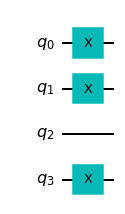

In [3]:
# Shifting operation
def shift_s(n, s):
    shift_s = QuantumCircuit(n)
    s = s[::-1]    # reverse s to fit qiskit's qubit ordering
    for i in range(n):
        if s[i] == '0':
            continue
        else:
            shift_s.x(i)
    shift_s.name = 'S(x)'
    return shift_s

shift_s(n, s).draw('mpl')

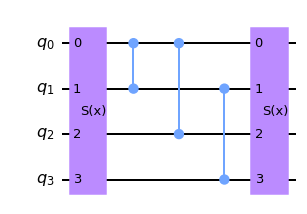

In [4]:
# Oracle g
def oracle_g(n):
    oracle_g = QuantumCircuit(n)
    oracle_g.append(shift_s(n, s), qargs=range(n))
    oracle_g.cz(0, 1)
    for i in range(int(n/2)):
        oracle_g.cz(i,i+int(n/2))
    oracle_g.append(shift_s(n, s), qargs=range(n))
    oracle_g.name = 'Oracle g'
    return oracle_g

oracle_g(n).draw('mpl')

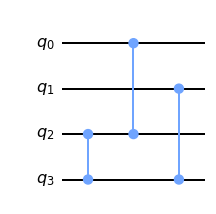

In [5]:
# Oracle f tilde
def oracle_f_tilde(n):
    oracle_f_tilde = QuantumCircuit(n)
    oracle_f_tilde.cz(2, 3)
    for i in range(int(n/2)):
        oracle_f_tilde.cz(i,i+int(n/2))
    oracle_f_tilde.name = 'Oracle f tilde'
    return oracle_f_tilde

oracle_f_tilde(n).draw('mpl')

Then we use implement the actual algorithm.

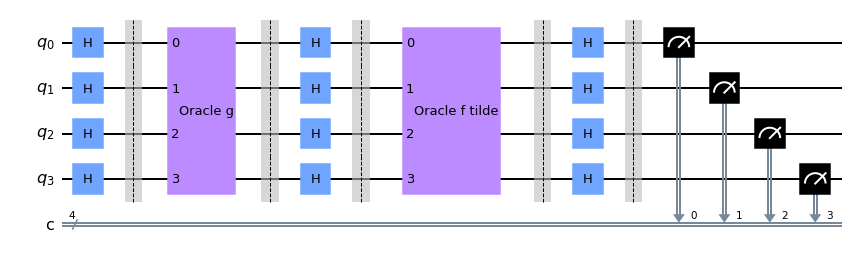

In [6]:
hsp_circuit = QuantumCircuit(n, n)

for i in range(n):
    hsp_circuit.h(i)
hsp_circuit.barrier()
hsp_circuit.append(oracle_g(n), range(n))
hsp_circuit.barrier()
for i in range(n):
    hsp_circuit.h(i)
hsp_circuit.barrier()
hsp_circuit.append(oracle_f_tilde(n), range(n))
hsp_circuit.barrier()
for i in range(n):
    hsp_circuit.h(i)
hsp_circuit.barrier()
for i in range(n):
    hsp_circuit.measure(i, i)

hsp_circuit.draw('mpl')

We can run the above circuit on the simulator. 

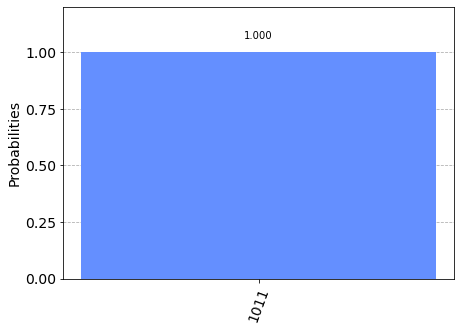

In [7]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
transpiled_hsp_circuit = transpile(hsp_circuit, aer_sim)
qobj = assemble(transpiled_hsp_circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

We can see that the result of the measurement is the hidden string 1011.

### 2.2 Experiment with Real Devices <a id='supo-device'> </a>

We can run the circuit on the real device as below.

In [9]:
# Load our saved IBMQ accounts and get the least busy backend device with more than or equal to 6 qubits
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q-skku','yonsei-uni','yu-students')
provider.backends()
backend = least_busy(provider.backends(filters=lambda x: int(x.configuration().n_qubits) <= 16 and
                                   int(x.configuration().n_qubits) >= 4 and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibm_lagos


In [10]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
transpiled_hsp_circuit = transpile(hsp_circuit, backend)
job = backend.run(transpiled_hsp_circuit, shots=shots)

job_monitor(job, interval=2)

Job Status: job has successfully run


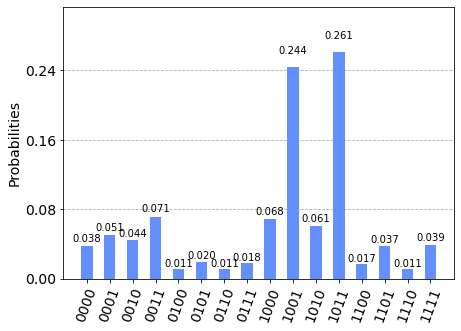

In [11]:
# Get the results from the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

As we can (hopefully) see, there is a significatly higher chance of measuring $\lvert1011\rangle$. The other results are due to errors in the quantum computation. 

## 3. Example: General Oracle <a id='geno'> </a>

Now we go through the more general case where the oracle $O$ does not provide the Foruier-transformed function $f$. We can employ the same function as before with $n=4$ and $s=1011$. The algorithm requires $2n+1$ qubits.

1. Apply Hadamard gates on every qubit.

2. Apply CNOT gates making the second register to be control qubits and the third register to be target qubits.

3. Apply the shifted function $g$ with the uncontrol qubit on the first register.

4. Apply the function $f$ with the control qubit on the first register.

5. Apply CNOT gates again

6. Apply Hadamard gates again.

7. Measure first two registers to find the outcome $(a_0, a)$, where $\left< a_0, a \middle| 1, s \right> = 0$

8. Characterize $s$ by repeating the algorithm.

### 3.1 Qiskit Implementation <a id='geno-simulation'> </a>

We'll now walk through the hidden-shift algorithm with general oracle. We employ the same function f as before.

In [11]:
def oracle_f(n):
    oracle_f = QuantumCircuit(n)
    oracle_f.cz(0, 1)
    for i in range(int(n/2)):
        oracle_f.cz(i,i+int(n/2))
    oracle_f.name = 'Oracle f'
    return oracle_f.to_gate()

def oracle_g(n, s):
    oracle_g = QuantumCircuit(n)
    oracle_g.compose(shift_s(n, s), inplace=True)
    oracle_g.append(oracle_f(n), range(n))
    oracle_g.compose(shift_s(n, s), inplace=True)
    oracle_g.name = 'Oracle g'
    return oracle_g.to_gate()

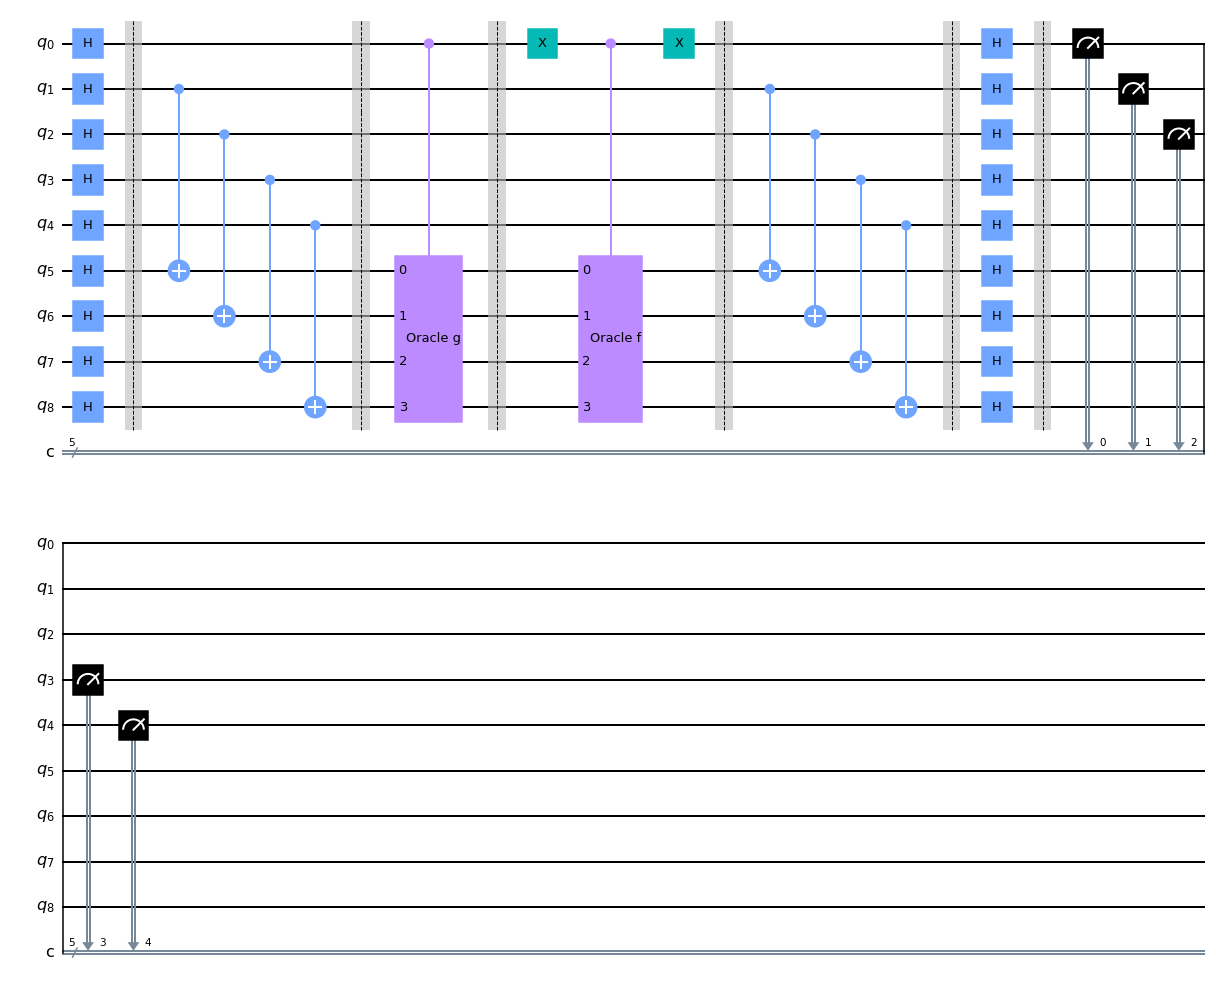

In [12]:
hsp_circuit = QuantumCircuit(2*n+1, n+1)

for i in range(2*n+1):
    hsp_circuit.h(i)
hsp_circuit.barrier()
for i in range(n):
    hsp_circuit.cx(i+1, i+n+1)
hsp_circuit.barrier()
hsp_circuit.append(oracle_g(n, s).control(), 
             [0] + [n+i+1 for i in range(n)])
hsp_circuit.barrier()
hsp_circuit.x(0)
hsp_circuit.append(oracle_f(n).control(), 
             [0] + [n+i+1 for i in range(n)])
hsp_circuit.x(0)
hsp_circuit.barrier()
for i in range(n):
    hsp_circuit.cx(i+1, i+n+1)
hsp_circuit.barrier()
for i in range(2*n+1):
    hsp_circuit.h(i)
hsp_circuit.barrier()
for i in range(n+1):
    hsp_circuit.measure(i, i)

hsp_circuit.draw('mpl')

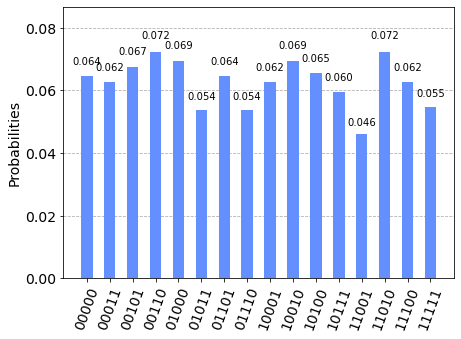

In [13]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
transpiled_hsp_circuit = transpile(hsp_circuit, aer_sim)
qobj = assemble(transpiled_hsp_circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

Now we see that there are 16 different results. Checking an inner product $\left<s, 1 \mid a \right>$, the results runs out like below:

|(s, 1) |   a   |product|(s, 1) |   a   |  product  |
|:-----:|:-----:|:-----:|:-----:|:-----:|:---------:|
| 10111 | 00000 |   0   | 10111 | 10001 |   1+1=0   |
| 10111 | 00011 | 1+1=0 | 10111 | 10010 |   1+1=0   |
| 10111 | 00101 | 1+1=0 | 10111 | 10100 |   1+1=0   |
| 10111 | 00110 | 1+1=0 | 10111 | 10111 | 1+1+1+1=0 |
| 10111 | 01000 |   0   | 10111 | 11001 |   1+1=0   |
| 10111 | 01011 | 1+1=0 | 10111 | 11010 |   1+1=0   |
| 10111 | 01101 | 1+1=0 | 10111 | 11100 |   1+1=0   |
| 10111 | 01110 | 1+1=0 | 10111 | 11111 | 1+1+1+1=0 |

### 3.2 Experiment with Real Devices <a id='geno-device'> </a>

We can run the circuit on the real device as below.

In [15]:
# Load our saved IBMQ accounts and get the least busy backend device with more than or equal to 6 qubits
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q-skku','yonsei-uni','yu-students')
provider.backends()
backend = least_busy(provider.backends(filters=lambda x: int(x.configuration().n_qubits) <= 2*(2*n+1) and
                                   int(x.configuration().n_qubits) >= 2*n+1 and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_guadalupe


In [16]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
transpiled_hsp_circuit = transpile(hsp_circuit, backend)
job = backend.run(transpiled_hsp_circuit, shots=shots)

job_monitor(job, interval=2)

Job Status: job has successfully run


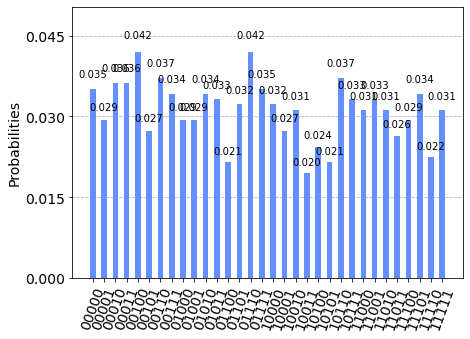

In [17]:
# Get the results from the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

In this case, we cannot distinguish which are the desired outputs in the noisy output. This issue could be tackled by improving the hardware.

## 4. Problems <a id='problems'> </a>

## 5. Breaking Poly1305 Encryption <a id="poly1305"> </a>

## 6. References <a id='references'> </a>

1. M. Roetteler (2008), "Quantum algorithms for highly non-linear Boolean functions", Proceedings of the 21st Annual ACM-SIAM Symposium on Discrete Algorithms (SODA'10), pp. 448-457, [arXiv:0811.3208](https://arxiv.org/abs/0811.3208) [quant-ph]
2. G. Kuperberg (2005), "A subexponential-time quantum algorithm for the dihedral hidden subgroup problem", SIAM Journal on Computing, 35(1), pp. 170-188, [doi:10.1137/S0097539703436345](https://doi.org/10.1137/S0097539703436345), [arXiv:quant-ph/0302112](https://arxiv.org/abs/quant-ph/0302112)
3. X. Bonnetain & M. Naya-Plasencia (2018), "Hidden Shift Quantum Cryptanalysis and Implications", In: T. Peyrin , S. Galbraith (eds) Advances in Cryptology – ASIACRYPT 2018, Lecture Notes in Computer Science, vol 11272, Springer, Cham, [doi:10.1007/978-3-030-03326-2_19](https://doi.org/10.1007/978-3-030-03326-2_19)
4. K. Wright, K. M. Beck, S. Debnath et al. (2019), "Benchmarking an 11-qubit quantum computer", Nat Commun 10, 5464, [doi:10.1038/s41467-019-13534-2](https://doi.org/10.1038/s41467-019-13534-2)
5. S. Bravyi & D. Gosset (2016), "Improved classical simulation of quantum circuits dominated by Clifford gates", Phys. Rev. Lett. 116, 250501, [doi:10.1103/PhysRevLett.116.250501](https://doi.org/10.1103/PhysRevLett.116.250501), [arXiv:1601.07601](https://arxiv.org/abs/1601.07601) [quant-ph]